Say we have a dataset like the following.

Populating the interactive namespace from numpy and matplotlib


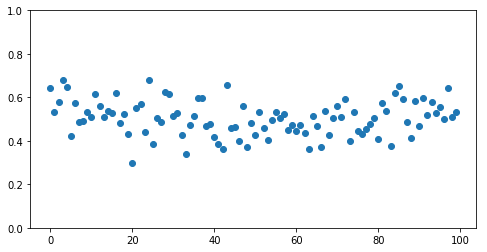

In [1]:
%pylab inline
from helpers import make_dataset, make_fig

X, y = make_dataset()
make_fig(X, y);

If we drew a line following the shape of the data, there would be a clear dip in the middle.

We could achieve by *rolling* through the data, taking the average of the 3 points we're looking at.

In [2]:
import pandas as pd

rolling = pd.Series(y).rolling(3).mean()

However, this completely throws away the first couple rows, as they don't have any historical data to average with

In [3]:
rolling[:5]

0         NaN
1         NaN
2    0.583812
3    0.596528
4    0.635658
dtype: float64

But by the middle of the dataset, we've got a pretty good representation going

In [4]:
rolling[50:60]

50    0.427411
51    0.480765
52    0.472817
53    0.465212
54    0.454143
55    0.479187
56    0.512444
57    0.521262
58    0.492924
59    0.481478
dtype: float64

Which allows us to make plots like this

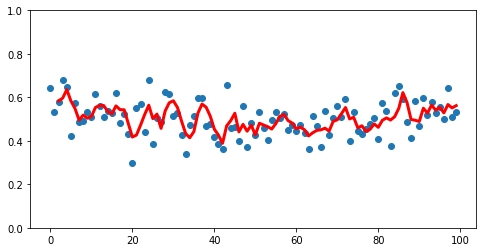

In [5]:
rolling = pd.Series(y).rolling(3).mean()
ax = make_fig(X, y)
ax.plot(X, rolling, linewidth=3, color='r');

And we can smooth this out by taking a larger value for the number of rolling rows to consider at once.

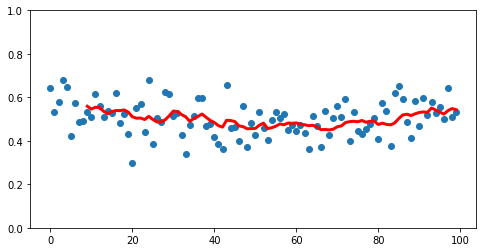

In [6]:
rolling = pd.Series(y).rolling(10).mean()
ax = make_fig(X, y)
ax.plot(X, rolling, linewidth=3, color='r');

However, this lops off more and more data from the beginning as we smooth.

## A Different Rolling Algorithm

Andrew Ng introduces an alternative approach in Week 2 of *Improving Deep Neural Networks* called *Exponentially Weighted Averages*. Consider a simple example where `xt` is the raw value at time *t* and `v` is the value of the algorithm.

$v_0 = 0$

$v_1 = 0.9v_0 + 0.1x_1$

$v_2 = 0.9v_1 + 0.1x_2$

$v_3 = 0.9v_2 + 0.1x_3$

$...$

Expanding out for `v3`, we get

$v_3 = 0.9(0.9v_1 + 0.1x_2) + 0.1x_3$

$v_3 = 0.9(0.9(0.9v_0 + 0.1x_1) + 0.1x_2) + 0.1x_3$

$v_3 = 0.9(0.9(0.9(0) + 0.1x_1) + 0.1x_2) + 0.1x_3$

Reducing, it quickly becomes obvious where the "Exponential" part comes in

$v_3 = 0.9^2 *0.1x_1 + 0.9*0.1x_2 + 0.1x_3$

### Another coefficient

In this example we used values `0.9` and `0.1`. More generally, we pick values `beta` and `1 - beta` that add up to one.

$v_t = \beta v_T + (1 - \beta)x_t$

$T = t-1$

(T substitution because LaTeX sucks with markdown, lol)

And since `beta` is less than one, as we move further and further into our `v` values, increasing the exponent attached to `beta`, it goes closer and closer to zero, thus giving less weight to historic values.

## Properties

### Smoothness

Because this weighting is multiplicative across all observations, it makes a much smoother curve. Compare our previous implementation of a naive rolling average

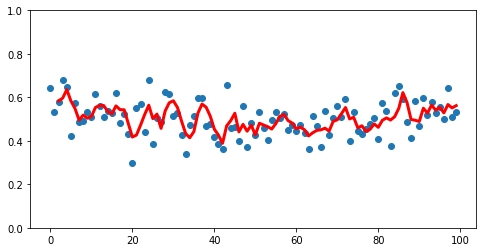

In [7]:
rolling = pd.Series(y).rolling(3).mean()

ax = make_fig(X, y)
ax.plot(X, rolling, linewidth=3, color='r');

To the less-noisy EWM approach

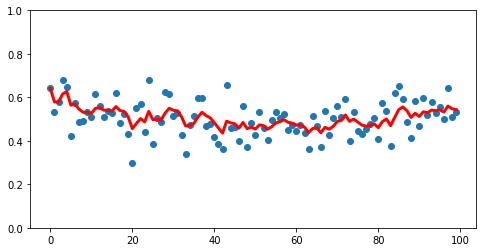

In [8]:
new_rolling = pd.Series(y).ewm(3).mean()

ax = make_fig(X, y)
ax.plot(X, new_rolling, linewidth=3, color='r');

Additionally, note starting with `v0=0`, we've got data for each point

### Sizing beta

Generally speaking, the higher your value for `beta`, the larger the exponent needs to be for the coefficient to approach zero

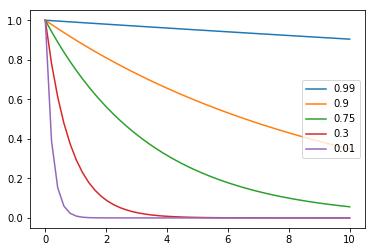

In [9]:
betas = [0.99, 0.9, 0.75, 0.3, 0.01]

xrange = np.linspace(0, 10)

for beta in betas:
    plt.plot(xrange, beta ** xrange, label=str(beta))
    
plt.legend(loc='right');

Therefore, **the higher your `beta`, the more days you consider at once in your rolling window**.

`beta=0.9` is pretty standard.

## Bias Correction

It's worth mentioning that the `pandas.ewm()` method did us a solid behind the scenes when we called it.

If you look back at our first dummy example, our value for `v0` was simply `0`. Thus when you plot out all of the `v`'s, you get the purple line-- starts off at `0`, but eventually represents a smooth average of values.

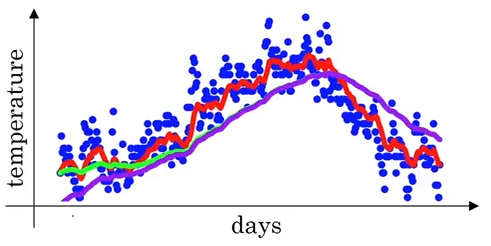

In [10]:
from IPython.display import Image

Image('images/bias_correction.png')

To get us plotting the green line, `pandas` actually used *Bias Correction* to correct for the fuzziness in early values. Essentially what this means is doing another step after the calculation of `vt` that involves dividing by 1 minus the bias term to the power of whatever step you're on

Concretely:

$\frac{v_t}{1 - \beta^t}$

Plotting that out over time, you can see that the denominator quickly goes to 1, thus becoming a non-factor in our calculation, and syncing up with the green line above.

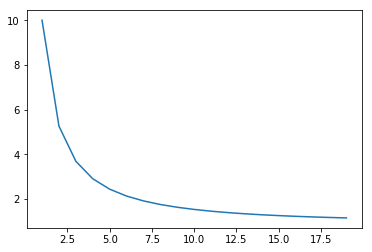

In [11]:
x = np.arange(1, 20, 1)
y = (1 / (1 - .9 ** x))

plt.plot(x, y);